# LightGBM with random split for early stopping

<https://www.kaggle.com/skooch/xgboost#Geo-aggregates>

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import lightgbm as lgb
import xgboost as xgb

from sklearn.metrics import f1_score
from joblib import Parallel, delayed
#from sklearn.externals.joblib import Parallel, delayed
from sklearn.base import clone
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings("ignore")

## 데이터 설명

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(train.shape)
print(test.shape)

(9557, 143)
(23856, 142)


In [3]:
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [4]:
test.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,18,121,324,1,0,1,0.25,64.00,NaN,324


__<데이터>__
- 기본 설명
    - 대회용 데이터이므로 test data label X
    - 각 행은 한 사람을 뜻함
    - 한 가구에 여러 사람 있을 수 있음. 
    - 평가할 때는 가구 내 중복을 막기 위해 가장 데이터만 사용!
    - 평가 지표: macro F1-score

- 주요 변수
    - Id: key값
    - Target(y): an ordinal variable indicating groups of income levels.
        - 1 = extreme poverty
        - 2 = moderate poverty
        - 3 = vulnerable households
        - 4 = non vulnerable households
    - idhogar: 각 가구에 대한 unique identifier. This can be used to create household-wide features, etc. All rows in a given household will have a matching value for this identifier.
    - parentesco1: 가장인지 여부
    
- 추가 변수 설명: <https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data>

## 전처리

### 전처리 함수 정의

#### idhogar: 문자형 --> 수치형

In [5]:
from sklearn.preprocessing import LabelEncoder

def encode_data(df):
    df['idhogar'] = LabelEncoder().fit_transform(df['idhogar'])

#### Decision Tree의 feature importance 그리기

In [6]:
def feature_importance(forest, X_train, display_results=True):
    ranked_list = []
    zero_features = []
    
    importances = forest.feature_importances_
    print('feature_importance:', importances)
    
    indices = np.argsort(importances)[::-1] ## array의 각 원소에 대해 순서 indices 반환
    
    if display_results:
        print("Feature ranking:")
    
    for f in range(X_train.shape[1]): # 각 feature에 대해
        if display_results:
            print("%d. feature %d (%f)" % (f+1, indices[f], importances[indices[f]]) + '-' + X_train.columns[indices[f]])
            
        ranked_list.append(X_train.columns[indices[f]])
        
        if importances[indices[f]] == 0.0:
            zero_features.append(X_train.columns[indices[f]])
            
    return ranked_list, zero_features

#### 변수 생성

In [7]:
def do_features(df):
    
    #변수 생성1: 두 변수 나눠서 변수 생성 (비율에 관한 변수)
    feats_div = [('children_fraction', 'r4t1', 'r4t3'), 
                 ('working_man_fraction', 'r4h2', 'r4t3'),
                 ('all_man_fraction', 'r4h3', 'r4t3'),
                 ('human_density', 'tamviv', 'rooms'),
                 ('human_bed_density', 'tamviv', 'bedrooms'),
                 ('rent_per_person', 'v2a1', 'r4t3'),
                 ('rent_per_room', 'v2a1', 'rooms'),
                 ('mobile_density', 'qmobilephone', 'r4t3'),
                 ('tablet_density', 'v18q1', 'r4t3'),
                 ('mobile_adult_density', 'qmobilephone', 'r4t2'),
                 ('tablet_adult_density', 'v18q1', 'r4t2')]
    
    for f_new, f1, f2 in feats_div:
        df['fe_' + f_new] = (df[f1] / df[f2]).astype(np.float32)
    
    
    #변수 생성2: 두 변수 빼서 변수 생성
    feats_sub = [('people_not_living', 'tamhog', 'tamviv'),
                 ('people_weird_stat', 'tamhog', 'r4t3')]
    
    for f_new, f1, f2 in feats_sub:
        df['fe_' + f_new] = (df[f1] - df[f2]).astype(np.float32)
        
    
    
    # 변수 생성3: 기초 통계값 생성
    
    aggs_num = {'age': ['min', 'max', 'mean'],
                'escolari': ['min', 'max', 'mean']}
    
    aggs_cat = {'dis': ['mean']}

    for s_ in ['estadocivil', 'parentesco', 'instlevel']: 
        for f_ in [f_ for f_ in df.columns if f_.startswith(s_)]: #위의 s_로 시작하는 column에 대해
            aggs_cat[f_] = ['mean', 'count'] # aggs_cat에 추가 변수 생성

    # aggregation over household
    for name_, df_ in [('18', df.query('age >= 18'))]: #name_: '18' , df_: df
        df_agg = df_.groupby('idhogar').agg({**aggs_num, **aggs_cat}).astype(np.float32) # 두 사전을 합친 후(**), 각 변수에 대해 주어진 통계값 연산
        df_agg.columns = pd.Index(['agg' + name_ + '_' + e[0] + "_" + e[1].upper() for e in df_agg.columns.tolist()])
        df = df.join(df_agg, how='left', on='idhogar')
        del df_agg

    # 변수 삭제
    df.drop(['Id'], axis=1, inplace=True)
    
    return df

__<변수생성 1>__

|index|변수명1|설명1|변수명2|설명2|
|-|------:|:----|------|:----|
|1|r4t1|persons younger than 12 years of age|r4t3|Total persons in the household
|2|r4h2|Males 12 years of age and older|r4t3|Total persons in the household|
|3|r4h3|Total males in the household|r4t3|Total persons in the household|
|4|tamviv|number of persons living in the household|rooms|number of all rooms in the house|
|5|tamviv|number of persons living in the household|bedrooms|number of bedrooms|
|6|v2a1|Monthly rent payment|r4t3|Total persons in the household|
|7|v2a1|Monthly rent payment|rooms|number of all rooms in the house|

__<변수생성 2>__

- estadocivil: 혼인 상태
    - estadocivil1, =1 if less than 10 years old
    - estadocivil2, =1 if free or coupled uunion
    - estadocivil3, =1 if married
    - estadocivil4, =1 if divorced
    - estadocivil5, =1 if separated
    - estadocivil6, =1 if widow/er
    - estadocivil7, =1 if single
    
    
- parentesco: 가정에서의 직위
    - parentesco1, =1 if household head
    - parentesco2, =1 if spouse/partner
    - parentesco3, =1 if son/doughter
    - parentesco4, =1 if stepson/doughter
    - parentesco5, =1 if son/doughter in law
    - parentesco6, =1 if grandson/doughter
    - parentesco7, =1 if mother/father
    - parentesco8, =1 if father/mother in law
    - parentesco9, =1 if brother/sister
    - parentesco10, =1 if brother/sister in law
    - parentesco11, =1 if other family member
    - parentesco12, =1 if other non family member


- instlevel: 교육 수준
    - instlevel1, =1 no level of education
    - instlevel2, =1 incomplete primary
    - instlevel3, =1 complete primary
    - instlevel4, =1 incomplete academic secondary level
    - instlevel5, =1 complete academic secondary level
    - instlevel6, =1 incomplete technical secondary level
    - instlevel7, =1 complete technical secondary level
    - instlevel8, =1 undergraduate and higher education
    - instlevel9, =1 postgraduate higher education

__<변수생성 3>__
- idhogar: 각 가구에 대한 unique identifier.

In [8]:
## 코드 이해 참고
aggs_num = {'age': ['min', 'max', 'mean'],
            'escolari': ['min', 'max', 'mean']}
aggs_cat = {'dis': ['mean']}
train.groupby('idhogar').agg({**aggs_num, **aggs_cat}).astype(np.float32)

age                  escolari                  dis
            min   max       mean      min   max      mean mean
idhogar                                                       
001ff74ca   0.0  38.0  19.000000      0.0  16.0  8.000000  0.0
003123ec2   1.0  24.0  12.750000      0.0   7.0  3.250000  0.0
004616164  16.0  50.0  33.000000      3.0  11.0  7.000000  0.0
004983866  16.0  59.0  37.500000      7.0   8.0  7.500000  0.0
005905417   6.0  32.0  17.333334      0.0   9.0  5.666667  0.0
...         ...   ...        ...      ...   ...       ...  ...
ff9343a35  24.0  55.0  39.500000      6.0  11.0  8.000000  0.0
ff9d5ab17   0.0  32.0  19.666666      0.0  16.0  9.000000  0.0
ffae4a097  54.0  68.0  61.000000      6.0  11.0  8.500000  0.0
ffe90d46f   9.0  53.0  31.250000      2.0   5.0  3.000000  0.0
fff7d6be1  40.0  74.0  56.000000      6.0  12.0  8.500000  0.0

[2988 rows x 7 columns]

#### Onehot Encoding 변수 => Label Encoding 변수

In [9]:
# convert one hot encoded fields to label encoding
def convert_OHE2LE(df):
    tmp_df = df.copy(deep=True) #deep=True: 원본 데이터가 변해도 안변함.
    for s_ in ['pared', 'piso', 'techo', 'abastagua', 'sanitario', 'energcocinar', 'elimbasu', 
               'epared', 'etecho', 'eviv', 'estadocivil', 'parentesco', 
               'instlevel', 'lugar', 'tipovivi',
               'manual_elec']:
        if 'manual_' not in s_: # 'manual_elec' 아니면 => 각 단어로 시작하는 변수 저장
            cols_s_ = [f_ for f_ in df.columns if f_.startswith(s_)]
        elif 'elec' in s_: # 'manual_elec' 이면 => 주어진 변수 사용
            cols_s_ = ['public', 'planpri', 'noelec', 'coopele']
        sum_ohe = tmp_df[cols_s_].sum(axis=1).unique() # 긱 행에 대해 합 값의 종류
        
        #deal with those OHE, where there is a sum over columns == 0
        if 0 in sum_ohe:
            print('The OHE in {} is incomplete. A new column will be added before label encoding'
                  .format(s_))
            # dummy colmn name to be added
            col_dummy = s_+'_dummy'
            # add the column to the dataframe
            tmp_df[col_dummy] = (tmp_df[cols_s_].sum(axis=1) == 0).astype(np.int8)
            # add the name to the list of columns to be label-encoded
            cols_s_.append(col_dummy)
            # proof-check, that now the category is complete
            sum_ohe = tmp_df[cols_s_].sum(axis=1).unique()
            if 0 in sum_ohe:
                 print("The category completion did not work")
        tmp_cat = tmp_df[cols_s_].idxmax(axis=1)
        tmp_df[s_ + '_LE'] = LabelEncoder().fit_transform(tmp_cat).astype(np.int16)
        if 'parentesco1' in cols_s_:
            cols_s_.remove('parentesco1')
        tmp_df.drop(cols_s_, axis=1, inplace=True)
    return tmp_df

### 전처리 시행

####  "idhogar: 문자형 --> 수치형" & "변수 생성"

In [10]:
def process_df(df_):
    # encode the idhogar
    encode_data(df_)
    
    # create aggregate features
    return do_features(df_)

train = process_df(train)
test = process_df(test)

#### 값 변경하기

In [11]:
train['dependency'] = np.sqrt(train['SQBdependency'])
test['dependency'] = np.sqrt(test['SQBdependency'])

In [12]:
train.loc[train['edjefa'] == "no", "edjefa"] = 0
train.loc[train['edjefe'] == "no", "edjefe"] = 0
test.loc[test['edjefa'] == "no", "edjefa"] = 0
test.loc[test['edjefe'] == "no", "edjefe"] = 0

In [13]:
train.loc[(train['edjefa'] == "yes") & (train['parentesco1'] == 1), "edjefa"] = train.loc[(train['edjefa'] == "yes") & (train['parentesco1'] == 1), "escolari"]
train.loc[(train['edjefe'] == "yes") & (train['parentesco1'] == 1), "edjefe"] = train.loc[(train['edjefe'] == "yes") & (train['parentesco1'] == 1), "escolari"]

test.loc[(test['edjefa'] == "yes") & (test['parentesco1'] == 1), "edjefa"] = test.loc[(test['edjefa'] == "yes") & (test['parentesco1'] == 1), "escolari"]
test.loc[(test['edjefe'] == "yes") & (test['parentesco1'] == 1), "edjefe"] = test.loc[(test['edjefe'] == "yes") & (test['parentesco1'] == 1), "escolari"]

In [14]:
train.loc[train['edjefa'] == "yes", "edjefa"] = 4
train.loc[train['edjefe'] == "yes", "edjefe"] = 4

test.loc[test['edjefa'] == "yes", "edjefa"] = 4
test.loc[test['edjefe'] == "yes", "edjefe"] = 4

#### Type 변환

In [15]:
train['edjefe'] = train['edjefe'].astype("int")
train['edjefa'] = train['edjefa'].astype("int")
test['edjefe'] = test['edjefe'].astype("int")
test['edjefa'] = test['edjefa'].astype("int")

#### edjef 변수 생성

In [16]:
train['edjef'] = np.max(train[['edjefa','edjefe']], axis=1)
test['edjef'] = np.max(test[['edjefa','edjefe']], axis=1)

#### 결측값 채우기

In [17]:
train['v2a1']=train['v2a1'].fillna(0)
test['v2a1']=test['v2a1'].fillna(0)

test['v18q1']=test['v18q1'].fillna(0)
train['v18q1']=train['v18q1'].fillna(0)

train['rez_esc']=train['rez_esc'].fillna(0)
test['rez_esc']=test['rez_esc'].fillna(0)

In [18]:
train.loc[train.meaneduc.isnull(), "meaneduc"] = 0
train.loc[train.SQBmeaned.isnull(), "SQBmeaned"] = 0

test.loc[test.meaneduc.isnull(), "meaneduc"] = 0
test.loc[test.SQBmeaned.isnull(), "SQBmeaned"] = 0

#### 데이터 오류 해결

In [19]:
train.loc[(train.v14a ==  1) & (train.sanitario1 ==  1) & (train.abastaguano == 0), "v14a"] = 0
train.loc[(train.v14a ==  1) & (train.sanitario1 ==  1) & (train.abastaguano == 0), "sanitario1"] = 0

test.loc[(test.v14a ==  1) & (test.sanitario1 ==  1) & (test.abastaguano == 0), "v14a"] = 0
test.loc[(test.v14a ==  1) & (test.sanitario1 ==  1) & (test.abastaguano == 0), "sanitario1"] = 0

#### "Onehot Encoding 변수 => Label Encoding 변수"

##### train과 test에 정의한 함수 적용하는 함수 생성

In [20]:
def train_test_apply_func(train_, test_, func_):
    test_['Target'] = 0
    xx = pd.concat([train_, test_])

    xx_func = func_(xx)
    train_ = xx_func.iloc[:train_.shape[0], :]
    test_  = xx_func.iloc[train_.shape[0]:, :].drop('Target', axis=1)

    del xx, xx_func
    return train_, test_

In [21]:
train, test = train_test_apply_func(train, test, convert_OHE2LE)

The OHE in techo is incomplete. A new column will be added before label encoding
The OHE in instlevel is incomplete. A new column will be added before label encoding
The OHE in manual_elec is incomplete. A new column will be added before label encoding


#### 거주 지역의 변수 통계량 붙이기

- lugar_LE: 사는 지역을 LabelEncoding한 것

In [22]:
cols_2_ohe = ['eviv_LE', 'etecho_LE', 'epared_LE', 'elimbasu_LE', 
              'energcocinar_LE', 'sanitario_LE', 'manual_elec_LE',
              'pared_LE']

cols_nums = ['age', 'meaneduc', 'dependency', 
             'hogar_nin', 'hogar_adul', 'hogar_mayor', 'hogar_total',
             'bedrooms', 'overcrowding']

def convert_geo2aggs(df_):
    tmp_df = pd.concat([df_[(['lugar_LE', 'idhogar']+cols_nums)],
                        pd.get_dummies(df_[cols_2_ohe], columns=cols_2_ohe)], # one_hot
                        axis=1)

    geo_agg = tmp_df.groupby(['lugar_LE','idhogar']).mean().groupby('lugar_LE').mean().astype(np.float32)
    geo_agg.columns = pd.Index(['geo_' + e for e in geo_agg.columns.tolist()])
    
    del tmp_df
    return df_.join(geo_agg, how='left', on='lugar_LE')

# add some aggregates by geography
train, test = train_test_apply_func(train, test, convert_geo2aggs)

In [23]:
## 코드 이해 참고
tmp_df = pd.concat([train[(['lugar_LE', 'idhogar']+cols_nums)],
                    pd.get_dummies(train[cols_2_ohe], 
                                   columns=cols_2_ohe)],axis=1)
geo_agg = tmp_df.groupby(['lugar_LE','idhogar']).mean().groupby('lugar_LE').mean().astype(np.float32)
geo_agg

,age,meaneduc,dependency,hogar_nin,hogar_adul,hogar_mayor,hogar_total,bedrooms,overcrowding,eviv_LE_0,...,manual_elec_LE_3,manual_elec_LE_4,pared_LE_0,pared_LE_1,pared_LE_2,pared_LE_3,pared_LE_4,pared_LE_5,pared_LE_6,pared_LE_7
lugar_LE,,,,,,,,,,,,,,,,,,,,,
0,40.075924,9.774446,1.409079,0.889267,2.308347,0.354344,3.197615,2.674617,1.321200,0.070982,...,0.001136,0.951732,0.677456,0.009654,0.001704,0.094832,0.001704,0.157297,0.011357,0.045997
1,38.531052,9.387654,1.021543,0.955556,2.333333,0.307407,3.288889,2.474074,1.445062,0.133333,...,0.000000,0.570370,0.618519,0.003704,0.000000,0.088889,0.003704,0.181481,0.011111,0.092593
2,36.865387,8.514721,1.174619,1.040609,2.010152,0.238579,3.050761,2.213198,1.543909,0.131980,...,0.000000,0.944162,0.548223,0.020305,0.000000,0.111675,0.000000,0.182741,0.025381,0.111675
3,37.081055,8.071382,1.392762,1.131474,2.099602,0.282869,3.231076,2.565737,1.394688,0.123506,...,0.000000,1.000000,0.366534,0.007968,0.000000,0.139442,0.000000,0.306773,0.000000,0.179283
4,35.529430,7.544099,1.185147,1.151625,2.101083,0.227437,3.252707,2.407942,1.475933,0.148014,...,0.000000,0.996390,0.483755,0.003610,0.003610,0.169675,0.000000,0.249097,0.007220,0.083032
5,36.644196,7.555388,1.361484,1.189655,2.181035,0.254310,3.370690,2.517241,1.474282,0.129310,...,0.000000,0.448276,0.465517,0.000000,0.004310,0.198276,0.000000,0.176724,0.000000,0.155172


#### num_over_18 변수 생성

- num_over_18: 가구 당 18세 이상의 인원수

In [24]:
train['num_over_18'] = 0
train['num_over_18'] = train[train.age >= 18].groupby('idhogar').transform("count")
train['num_over_18'] = train.groupby("idhogar")["num_over_18"].transform("max") # age <18 에 대해서도 채워주기 위해
train['num_over_18'] = train['num_over_18'].fillna(0) # 결측값 0으로 채우기

test['num_over_18'] = 0
test['num_over_18'] = test[test.age >= 18].groupby('idhogar').transform("count")
test['num_over_18'] = test.groupby("idhogar")["num_over_18"].transform("max")
test['num_over_18'] = test['num_over_18'].fillna(0)

#### 변수 생성 - 비율

In [25]:
def extract_features(df):
    df['bedrooms_to_rooms'] = df['bedrooms']/df['rooms']
    df['rent_to_rooms'] = df['v2a1']/df['rooms']
    df['tamhog_to_rooms'] = df['tamhog']/df['rooms'] # tamhog - size of the household
    df['r4t3_to_tamhog'] = df['r4t3']/df['tamhog'] # r4t3 - Total persons in the household
    df['r4t3_to_rooms'] = df['r4t3']/df['rooms'] # r4t3 - Total persons in the household
    df['v2a1_to_r4t3'] = df['v2a1']/df['r4t3'] # rent to people in household
    df['v2a1_to_r4t3'] = df['v2a1']/(df['r4t3'] - df['r4t1']) # rent to people under age 12
    df['hhsize_to_rooms'] = df['hhsize']/df['rooms'] # rooms per person
    df['rent_to_hhsize'] = df['v2a1']/df['hhsize'] # rent to household size
    df['rent_to_over_18'] = df['v2a1']/df['num_over_18']
    # some households have no one over 18, use the total rent for those
    df.loc[df.num_over_18 == 0, "rent_to_over_18"] = df[df.num_over_18 == 0].v2a1
    
extract_features(train)    
extract_features(test)   

#### 중복된 column 삭제하기

In [26]:
# drop duplicated columns
needless_cols = ['r4t3', 'tamhog', 'tamviv', 'hhsize', 'v18q', 'v14a', 'agesq',
                 'mobilephone', 'female', ]

instlevel_cols = [s for s in train.columns.tolist() if 'instlevel' in s]

needless_cols.extend(instlevel_cols)

train = train.drop(needless_cols, axis=1)
test = test.drop(needless_cols, axis=1)

#### train_test_split

- kaggle에서는 대회용 test 데이터를 제공하지만, y label이 없기 때문에 모델 평가를 위해 kaggle에서 제공한 train 데이터로 다시 train_test_split

- 같은 가구면 대체로 y(소득분위) 같음 => 가구별로 data 나눔


In [47]:
def split_data(train, y, sample_weight=None, households=None, test_percentage=0.20, seed=None):
    # uncomment for extra randomness
#     np.random.seed(seed=seed)
    
    train2 = train.copy()
    
    # pick some random households to use for the test data
    cv_hhs = np.random.choice(households, size=int(len(households) * test_percentage), replace=False)
    
    # select households which are in the random selection
    cv_idx = np.isin(households, cv_hhs)
    X_test = train2[cv_idx]
    y_test = y[cv_idx]

    X_train = train2[~cv_idx]
    y_train = y[~cv_idx]
    
    if sample_weight is not None:
        y_train_weights = sample_weight[~cv_idx]
        return X_train, y_train, X_test, y_test, y_train_weights
    
    return X_train, y_train, X_test, y_test

In [27]:
X = train.query('parentesco1==1') #parentesco1==1: the head of the household.
# X = train.copy()

# pull out and drop the target variable
y = X['Target'] - 1 # 1~4 => 0~3
X = X.drop(['Target'], axis=1)

np.random.seed(seed=2021)

train2 = X.copy()

train_hhs = train2.idhogar #idhogar: 가구 unique id

households = train2.idhogar.unique() # 가구별로
cv_hhs = np.random.choice(households, size=int(len(households) * 0.15), replace=False)
print(cv_hhs)

cv_idx = np.isin(train2.idhogar, cv_hhs) # 15%로 랜덤하게 뽑은 가구명의 index

# 1. kaggle에서 train으로 준 데이터를 train/test로 나누기
X_test = train2[cv_idx]
y_test = y[cv_idx]

X_train = train2[~cv_idx]
y_train = y[~cv_idx]

'''
# 2. kaggle에서 train으로 준 데이터를 모두 train에 사용
X_train = train2
y_train = y
'''

train_households = X_train.idhogar

[1304 2506 2569  221  573 2103 2455   66 2935 2348  181    0 1406 1630
 2735  771    2 1924 1084  852 1384 1514  461 2310  910 1649 1823 1911
 1511 1738 1001 2874 2331 1009  339  692 1429 1549   21  892  277 2713
 1079 1669 1590   79 2514 1063 1513  325  239 1083 1287 2823  130 1729
   12 1236  987 1766 2832 1544 2505 2086  863 2247 1257  257  320 1716
  899 1243  121  397  700  236 2927 1903 2484 2043 1075  939 1405 2187
 1337 1358 1712 2752  649  449   62 2076 1021 2866  394 1950  146 1682
 1280 1817 1963 2428 2938  363 1981 1541 1454  165 1502 2013  628 1929
 1206 1737 1176 1752  982 2489 2173   24 1584 1183 1689  965 1327 1082
 1330 1272 1527  607 2352 2478 1042 2203  848 2759 1090 1736 1928  567
 2025 1332 1512 1234 1299 2516 2046 2249  223 1930 1089 1403 1034 1827
 1587 1910  642 1826 2779 2625 1211 2774 1748 1203 1717 2891  340  953
 1702 2937 1364 2936 2641 1127 1572 2530  373 1901 1273 2786  251 2080
 1107 1100  229 2635 2768 1333  480 1455 2919  422 2125 2140 2896  679
  271 

y의 각 class별 가중치 확인

In [28]:
y_train.value_counts()

3    1659
1     380
2     304
0     185
Name: Target, dtype: int64

In [29]:
# figure out the class weights for training with unbalanced classes
from sklearn.utils import class_weight

y_train_weights = class_weight.compute_sample_weight('balanced', y_train, indices=None)
pd.Series(y_train_weights).value_counts()

0.380952    1659
1.663158     380
2.078947     304
3.416216     185
dtype: int64

#### LGBM에서 drop할 변수 지정

In [30]:
# drop some features which aren't used by the LGBM or have very low importance
extra_drop_features = [
 'agg18_estadocivil1_MEAN',
 'agg18_estadocivil6_COUNT',
 'agg18_estadocivil7_COUNT',
 'agg18_parentesco10_COUNT',
 'agg18_parentesco11_COUNT',
 'agg18_parentesco12_COUNT',
 'agg18_parentesco1_COUNT',
 'agg18_parentesco2_COUNT',
 'agg18_parentesco3_COUNT',
 'agg18_parentesco4_COUNT',
 'agg18_parentesco5_COUNT',
 'agg18_parentesco6_COUNT',
 'agg18_parentesco7_COUNT',
 'agg18_parentesco8_COUNT',
 'agg18_parentesco9_COUNT',
 'geo_elimbasu_LE_4',
 'geo_energcocinar_LE_1',
 'geo_energcocinar_LE_2',
 'geo_epared_LE_0',
 'geo_hogar_mayor',
 'geo_manual_elec_LE_2',
 'geo_pared_LE_3',
 'geo_pared_LE_4',
 'geo_pared_LE_5',
 'geo_pared_LE_6',
 'num_over_18',
 'parentesco_LE',
 'rez_esc']

In [31]:
xgb_drop_cols = extra_drop_features + ["idhogar",  'parentesco1']

## Fit a Voting Classifier

### 하이퍼파라미터 튜닝
scipy의 Random Search를 이용하여 하이퍼파라미터 튜닝
```python
param_test ={'num_leaves': sp_randint(12, 20), 
             'min_child_samples': sp_randint(40, 100), 
             #'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.75, scale=0.25), 
             'colsample_bytree': sp_uniform(loc=0.8, scale=0.15)#,
             #'reg_alpha': [0, 1e-3, 1e-1, 1, 10, 50, 100],
             #'reg_lambda': [0, 1e-3, 1e-1, 1, 10, 50, 100]
            }
```

In [32]:
opt_parameters = {'max_depth':35, 'eta':0.1, 'silent':0, 'objective':'multi:softmax', 'min_child_weight': 1, 'num_class': 4, 'gamma': 2.0, 'colsample_bylevel': 0.9, 'subsample': 0.84, 'colsample_bytree': 0.88, 'reg_lambda': 0.40 }
opt_parameters = {'max_depth':35, 'eta':0.15, 'silent':1, 'objective':'multi:softmax', 'min_child_weight': 2, 'num_class': 4, 'gamma': 2.5, 'colsample_bylevel': 1, 'subsample': 0.95, 'colsample_bytree': 0.85, 'reg_lambda': 0.35 }

### 학습 파라미터 설정

#### 평가지표 macro F1-score으로 설정

In [64]:
def evaluate_macroF1_lgb(predictions, truth):  
    # this follows the discussion in https://github.com/Microsoft/LightGBM/issues/1483
    pred_labels = predictions.argmax(axis=1)
    truth = truth.get_label()
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', 1-f1) 

In [34]:
fit_params={"early_stopping_rounds":500,
            "eval_metric" : evaluate_macroF1_lgb, 
            "eval_set" : [(X_train,y_train), (X_test,y_test)],
            'verbose': False,
           }

#### learning_rate 설정

In [35]:
def learning_rate_power_0997(current_iter):
    base_learning_rate = 0.1
    min_learning_rate = 0.02
    lr = base_learning_rate  * np.power(.995, current_iter)
    return max(lr, min_learning_rate)

#### verbose 설정

In [36]:
fit_params['verbose'] = 50

### VotingClassifierLGBM 정의

In [48]:
np.random.seed(100)

def _parallel_fit_estimator(estimator1, X, y, sample_weight=None, threshold=True, **fit_params):
    estimator = clone(estimator1)
    
    # randomly split the data so we have a test set for early stopping
    if sample_weight is not None:
        X_train, y_train, X_test, y_test, y_train_weight = split_data(X, y, sample_weight, households=train_households)
    else:
        X_train, y_train, X_test, y_test = split_data(X, y, None, households=train_households)
        
    # update the fit params with our new split
    fit_params["eval_set"] = [(X_test,y_test)]
    
    # fit the estimator
    if sample_weight is not None:
        if isinstance(estimator1, ExtraTreesClassifier) or isinstance(estimator1, RandomForestClassifier):
            estimator.fit(X_train, y_train)
        else:
            _ = estimator.fit(X_train, y_train, sample_weight=y_train_weight, **fit_params)
    else:
        if isinstance(estimator1, ExtraTreesClassifier) or isinstance(estimator1, RandomForestClassifier):
            estimator.fit(X_train, y_train)
        else:
            _ = estimator.fit(X_train, y_train, **fit_params)
    
    if not isinstance(estimator1, ExtraTreesClassifier) and not isinstance(estimator1, RandomForestClassifier) and not isinstance(estimator1, xgb.XGBClassifier):
        best_cv_round = np.argmax(estimator.evals_result_['validation_0']['mlogloss'])
        best_cv = np.max(estimator.evals_result_['validation_0']['mlogloss'])
        best_train = estimator.evals_result_['train']['macroF1'][best_cv_round]
    else:
        best_train = f1_score(y_train, estimator.predict(X_train), average="macro")
        best_cv = f1_score(y_test, estimator.predict(X_test), average="macro")
        print("Train F1:", best_train)
        print("Test F1:", best_cv)
        
    # reject some estimators based on their performance on train and test sets
    if threshold:
        # if the valid score is very high we'll allow a little more leeway with the train scores
        if ((best_cv > 0.37) and (best_train > 0.75)) or ((best_cv > 0.44) and (best_train > 0.65)):
            return estimator

        # else recurse until we get a better one
        else:
            print("Unacceptable!!! Trying again...")
            return _parallel_fit_estimator(estimator1, X, y, sample_weight=sample_weight, **fit_params)
    
    else:
        return estimator

In [49]:
class VotingClassifierLGBM(VotingClassifier):
    '''
    This implements the fit method of the VotingClassifier propagating fit_params
    '''
    def fit(self, X, y, sample_weight=None, threshold=True, **fit_params):
        
        if isinstance(y, np.ndarray) and len(y.shape) > 1 and y.shape[1] > 1:
            raise NotImplementedError('Multilabel and multi-output'
                                      ' classification is not supported.')

        if self.voting not in ('soft', 'hard'):
            raise ValueError("Voting must be 'soft' or 'hard'; got (voting=%r)"
                             % self.voting)

        if self.estimators is None or len(self.estimators) == 0:
            raise AttributeError('Invalid `estimators` attribute, `estimators`'
                                 ' should be a list of (string, estimator)'
                                 ' tuples')

        if (self.weights is not None and
                len(self.weights) != len(self.estimators)):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d estimators'
                             % (len(self.weights), len(self.estimators)))

        names, clfs = zip(*self.estimators)
        self._validate_names(names)

        n_isnone = np.sum([clf is None for _, clf in self.estimators])
        if n_isnone == len(self.estimators):
            raise ValueError('All estimators are None. At least one is '
                             'required to be a classifier!')

        self.le_ = LabelEncoder().fit(y)
        self.classes_ = self.le_.classes_
        self.estimators_ = []

        transformed_y = self.le_.transform(y)

        self.estimators_ = Parallel(n_jobs=self.n_jobs)(
                delayed(_parallel_fit_estimator)(clone(clf), X, transformed_y,
                                                 sample_weight=sample_weight, threshold=threshold, **fit_params)
                for clf in clfs if clf is not None)

        return self

### 학습

- **dict이 함수 안에 있을 때: take all additional named arguments to this function and insert them into this parameter as dictionary entries.

#### Voting에 사용할 각 모델 넣기

In [67]:
clfs = []
for i in range(15):
    clf = xgb.XGBClassifier(random_state=217+i, n_estimators=300, learning_rate=0.15, n_jobs=4, **opt_parameters)
    
    clfs.append(('xgb{}'.format(i), clf))

print(clfs)

[('xgb0', XGBClassifier(colsample_bytree=0.85, eta=0.15, gamma=2.5, learning_rate=0.15,
              max_depth=35, min_child_weight=2, n_estimators=300, n_jobs=4,
              num_class=4, objective='multi:softmax', random_state=217,
              reg_lambda=0.35, silent=1, subsample=0.95)), ('xgb1', XGBClassifier(colsample_bytree=0.85, eta=0.15, gamma=2.5, learning_rate=0.15,
              max_depth=35, min_child_weight=2, n_estimators=300, n_jobs=4,
              num_class=4, objective='multi:softmax', random_state=218,
              reg_lambda=0.35, silent=1, subsample=0.95)), ('xgb2', XGBClassifier(colsample_bytree=0.85, eta=0.15, gamma=2.5, learning_rate=0.15,
              max_depth=35, min_child_weight=2, n_estimators=300, n_jobs=4,
              num_class=4, objective='multi:softmax', random_state=219,
              reg_lambda=0.35, silent=1, subsample=0.95)), ('xgb3', XGBClassifier(colsample_bytree=0.85, eta=0.15, gamma=2.5, learning_rate=0.15,
              max_depth=35, mi

#### 학습시키기

```python
fit_params={"early_stopping_rounds":500,
            "eval_metric" : evaluate_macroF1_lgb, 
            "eval_set" : [(X_train,y_train), (X_test,y_test)],
            'verbose': False,
           }
```

In [50]:
vc = VotingClassifierLGBM(clfs, voting='soft')
del(clfs)

#Train the final model with learning rate decay
_ = vc.fit(X_train.drop(xgb_drop_cols, axis=1), y_train, sample_weight=y_train_weights, threshold=False, **fit_params)

clf_final = vc.estimators_[0]

[0]	validation_0-merror:0.437624	validation_0-macroF1:0.596889
Multiple eval metrics have been passed: 'validation_0-macroF1' will be used for early stopping.

Will train until validation_0-macroF1 hasn't improved in 500 rounds.
[50]	validation_0-merror:0.386139	validation_0-macroF1:0.571869
[100]	validation_0-merror:0.384158	validation_0-macroF1:0.581812
[150]	validation_0-merror:0.368317	validation_0-macroF1:0.559774
[200]	validation_0-merror:0.372277	validation_0-macroF1:0.561391
[250]	validation_0-merror:0.372277	validation_0-macroF1:0.563525
[299]	validation_0-merror:0.372277	validation_0-macroF1:0.562995
Train F1: 0.9245630760562777
Test F1: 0.4466656333048567
[0]	validation_0-merror:0.455446	validation_0-macroF1:0.658327
Multiple eval metrics have been passed: 'validation_0-macroF1' will be used for early stopping.

Will train until validation_0-macroF1 hasn't improved in 500 rounds.
[50]	validation_0-merror:0.39604	validation_0-macroF1:0.588783
[100]	validation_0-merror:0.39604

Will train until validation_0-macroF1 hasn't improved in 500 rounds.
[50]	validation_0-merror:0.372277	validation_0-macroF1:0.549316
[100]	validation_0-merror:0.380198	validation_0-macroF1:0.565527
[150]	validation_0-merror:0.374257	validation_0-macroF1:0.555113
[200]	validation_0-merror:0.376238	validation_0-macroF1:0.560936
[250]	validation_0-merror:0.376238	validation_0-macroF1:0.558224
[299]	validation_0-merror:0.374257	validation_0-macroF1:0.552794
Train F1: 0.8711482330603465
Test F1: 0.457236754077145
[0]	validation_0-merror:0.477228	validation_0-macroF1:0.638566
Multiple eval metrics have been passed: 'validation_0-macroF1' will be used for early stopping.

Will train until validation_0-macroF1 hasn't improved in 500 rounds.
[50]	validation_0-merror:0.376238	validation_0-macroF1:0.56216
[100]	validation_0-merror:0.374257	validation_0-macroF1:0.564459
[150]	validation_0-merror:0.370297	validation_0-macroF1:0.564006
[200]	validation_0-merror:0.366337	validation_0-macroF1:0.56517


In [68]:
clf_final

XGBClassifier(colsample_bytree=0.85, eta=0.15, gamma=2.5, learning_rate=0.15,
              max_depth=35, min_child_weight=2, n_estimators=300, n_jobs=4,
              num_class=4, objective='multi:softprob', random_state=217,
              reg_lambda=0.35, silent=1, subsample=0.95)

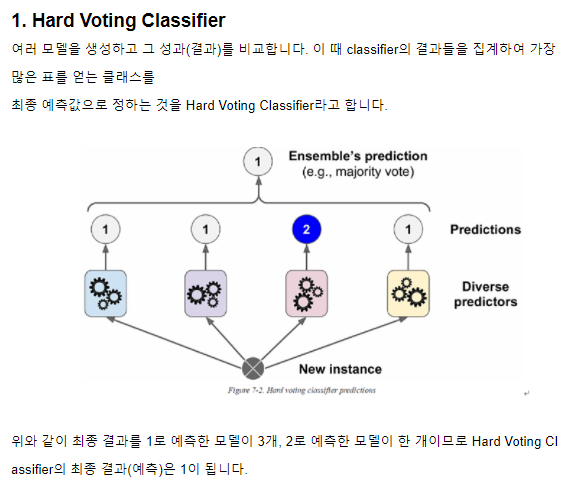

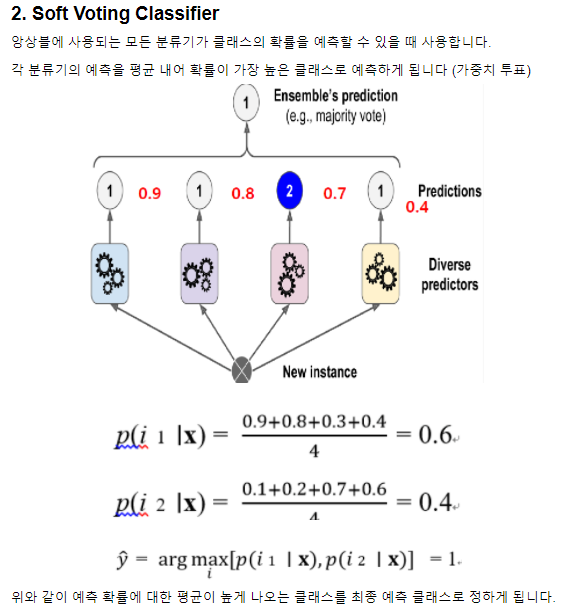

#### 학습 결과 확인 (validation score)

In [51]:
# params 4 - 400 early stop - 15 estimators - l1 used features - weighted
global_score = f1_score(y_test, clf_final.predict(X_test.drop(xgb_drop_cols, axis=1)), average='macro')
vc.voting = 'soft'
global_score_soft = f1_score(y_test, vc.predict(X_test.drop(xgb_drop_cols, axis=1)), average='macro')
vc.voting = 'hard'
global_score_hard = f1_score(y_test, vc.predict(X_test.drop(xgb_drop_cols, axis=1)), average='macro')

print('Validation score of a single LGBM Classifier: {:.4f}'.format(global_score))
print('Validation score of a VotingClassifier on 3 LGBMs with soft voting strategy: {:.4f}'.format(global_score_soft))
print('Validation score of a VotingClassifier on 3 LGBMs with hard voting strategy: {:.4f}'.format(global_score_hard))

Validation score of a single LGBM Classifier: 0.4246
Validation score of a VotingClassifier on 3 LGBMs with soft voting strategy: 0.4759
Validation score of a VotingClassifier on 3 LGBMs with hard voting strategy: 0.4702


### 필요없는 변수 drop하기

In [70]:
useless_features = []
drop_features = set()
counter = 0
for est in vc.estimators_:
    ranked_features, unused_features = feature_importance(est, X_train.drop(xgb_drop_cols, axis=1), display_results=False)
    useless_features.append(unused_features)
    if counter == 0:
        drop_features = set(unused_features)
    else:
        drop_features = drop_features.intersection(set(unused_features))
    counter += 1

feature_importance: [0.00572495 0.00213819 0.00839015 0.01352887 0.0115964  0.00812325
 0.007285   0.01018233 0.0081433  0.00589517 0.00780508 0.00697076
 0.01151819 0.00691288 0.00693417 0.00733659 0.00667867 0.00947548
 0.00856266 0.00647173 0.00454601 0.00813592 0.01027309 0.00926375
 0.00687871 0.00939216 0.00732291 0.00840371 0.00443163 0.0086561
 0.00604635 0.00639533 0.00875625 0.00760091 0.00665459 0.00780943
 0.0048225  0.0083488  0.00883844 0.0092982  0.01132123 0.00642825
 0.01288234 0.00804614 0.00898944 0.00798542 0.00306627 0.00781769
 0.00648187 0.01324977 0.00696216 0.0076654  0.00640262 0.00374438
 0.         0.0075468  0.00706008 0.00790962 0.00778599 0.02168818
 0.01169659 0.00899435 0.00508687 0.01000766 0.00311793 0.00822666
 0.         0.00506389 0.         0.0134125  0.         0.00884823
 0.00739755 0.         0.01209546 0.00733396 0.00238817 0.00555183
 0.00727751 0.00579335 0.         0.00622371 0.         0.00245779
 0.00301025 0.         0.00946307 0.0082385

feature_importance: [0.00679315 0.00283763 0.00858227 0.00288167 0.00640049 0.00987706
 0.00714516 0.00800848 0.00852794 0.00821169 0.00830084 0.00760286
 0.0059821  0.00883476 0.00757384 0.00784551 0.00719651 0.01710862
 0.00867929 0.00737264 0.00455092 0.00654116 0.01138026 0.00953712
 0.0077516  0.00885253 0.00762209 0.00975802 0.00661456 0.00939897
 0.00716843 0.00773739 0.00692958 0.00742056 0.00706696 0.00809202
 0.00906992 0.01062538 0.01846513 0.00573198 0.00900977 0.00828022
 0.0128028  0.00754942 0.00847171 0.00808204 0.00954349 0.00748403
 0.0070016  0.01024726 0.00669204 0.00757799 0.00718898 0.00269062
 0.00393604 0.00812096 0.00697914 0.00682394 0.00814401 0.02085887
 0.01095235 0.00697165 0.01109956 0.01280875 0.         0.00870433
 0.         0.0062679  0.00779324 0.01297134 0.         0.00764839
 0.00799389 0.00392146 0.01489882 0.00577008 0.01008326 0.00845822
 0.0034738  0.0066685  0.         0.00437078 0.         0.0032712
 0.00359764 0.         0.00835964 0.0079372

In [71]:
drop_features

{'agg18_estadocivil5_COUNT', 'geo_energcocinar_LE_0'}

In [53]:
ranked_features = feature_importance(clf_final, X_train.drop(xgb_drop_cols, axis=1))

feature_importance: [0.00572495 0.00213819 0.00839015 0.01352887 0.0115964  0.00812325
 0.007285   0.01018233 0.0081433  0.00589517 0.00780508 0.00697076
 0.01151819 0.00691288 0.00693417 0.00733659 0.00667867 0.00947548
 0.00856266 0.00647173 0.00454601 0.00813592 0.01027309 0.00926375
 0.00687871 0.00939216 0.00732291 0.00840371 0.00443163 0.0086561
 0.00604635 0.00639533 0.00875625 0.00760091 0.00665459 0.00780943
 0.0048225  0.0083488  0.00883844 0.0092982  0.01132123 0.00642825
 0.01288234 0.00804614 0.00898944 0.00798542 0.00306627 0.00781769
 0.00648187 0.01324977 0.00696216 0.0076654  0.00640262 0.00374438
 0.         0.0075468  0.00706008 0.00790962 0.00778599 0.02168818
 0.01169659 0.00899435 0.00508687 0.01000766 0.00311793 0.00822666
 0.         0.00506389 0.         0.0134125  0.         0.00884823
 0.00739755 0.         0.01209546 0.00733396 0.00238817 0.00555183
 0.00727751 0.00579335 0.         0.00622371 0.         0.00245779
 0.00301025 0.         0.00946307 0.0082385

## Random Forest 

In [54]:
et_drop_cols = ['agg18_age_MAX', 'agg18_age_MEAN', 'agg18_age_MIN', 'agg18_dis_MEAN',
       'agg18_escolari_MAX', 'agg18_escolari_MEAN', 'agg18_escolari_MIN',
       'agg18_estadocivil1_COUNT', 'agg18_estadocivil1_MEAN',
       'agg18_estadocivil2_COUNT', 'agg18_estadocivil2_MEAN',
       'agg18_estadocivil3_COUNT', 'agg18_estadocivil3_MEAN',
       'agg18_estadocivil4_COUNT', 'agg18_estadocivil4_MEAN',
       'agg18_estadocivil5_COUNT', 'agg18_estadocivil5_MEAN',
       'agg18_estadocivil6_COUNT', 'agg18_estadocivil6_MEAN',
       'agg18_estadocivil7_COUNT', 'agg18_estadocivil7_MEAN',
       'agg18_parentesco10_COUNT', 'agg18_parentesco10_MEAN',
       'agg18_parentesco11_COUNT', 'agg18_parentesco11_MEAN',
       'agg18_parentesco12_COUNT', 'agg18_parentesco12_MEAN',
       'agg18_parentesco1_COUNT', 'agg18_parentesco1_MEAN',
       'agg18_parentesco2_COUNT', 'agg18_parentesco2_MEAN',
       'agg18_parentesco3_COUNT', 'agg18_parentesco3_MEAN',
       'agg18_parentesco4_COUNT', 'agg18_parentesco4_MEAN',
       'agg18_parentesco5_COUNT', 'agg18_parentesco5_MEAN',
       'agg18_parentesco6_COUNT', 'agg18_parentesco6_MEAN',
       'agg18_parentesco7_COUNT', 'agg18_parentesco7_MEAN',
       'agg18_parentesco8_COUNT', 'agg18_parentesco8_MEAN',
       'agg18_parentesco9_COUNT', 'agg18_parentesco9_MEAN'] #+ ['parentesco_LE', 'rez_esc']

et_drop_cols.extend(["idhogar", "parentesco1", 'fe_rent_per_person', 'fe_rent_per_room',
       'fe_tablet_adult_density', 'fe_tablet_density'])

In [55]:
# do the same thing for some extra trees classifiers
ets = []    
for i in range(10):
    rf = RandomForestClassifier(max_depth=None, random_state=217+i, n_jobs=4, n_estimators=700, min_impurity_decrease=1e-3, min_samples_leaf=2, verbose=0, class_weight="balanced")
    ets.append(('rf{}'.format(i), rf))   

vc2 = VotingClassifierLGBM(ets, voting='soft')    
_ = vc2.fit(X_train.drop(et_drop_cols, axis=1), y_train, threshold=False)    

Train F1: 0.9311705990307115
Test F1: 0.42280030291414195
Train F1: 0.9273898969918545
Test F1: 0.39824218075702156
Train F1: 0.9313927260916385
Test F1: 0.452688201247652
Train F1: 0.9189462580913688
Test F1: 0.3865743491368041
Train F1: 0.9210159196423228
Test F1: 0.38088141051531843
Train F1: 0.9244621532164365
Test F1: 0.3976518887876843
Train F1: 0.9289909831402969
Test F1: 0.40176949752231805
Train F1: 0.9324854031870814
Test F1: 0.4562391688971555
Train F1: 0.9212857168689219
Test F1: 0.39263672114889314
Train F1: 0.9239900028826891
Test F1: 0.4386109295654641


In [56]:
# w/ threshold, extra drop cols
vc2.voting = 'soft'
global_rf_score_soft = f1_score(y_test, vc2.predict(X_test.drop(et_drop_cols, axis=1)), average='macro')
vc2.voting = 'hard'
global_rf_score_hard = f1_score(y_test, vc2.predict(X_test.drop(et_drop_cols, axis=1)), average='macro')

print('Validation score of a VotingClassifier on 3 LGBMs with soft voting strategy: {:.4f}'.format(global_rf_score_soft))
print('Validation score of a VotingClassifier on 3 LGBMs with hard voting strategy: {:.4f}'.format(global_rf_score_hard))

Validation score of a VotingClassifier on 3 LGBMs with soft voting strategy: 0.4583
Validation score of a VotingClassifier on 3 LGBMs with hard voting strategy: 0.4601


In [57]:
# w/o threshold, extra drop cols
vc2.voting = 'soft'
global_rf_score_soft = f1_score(y_test, vc2.predict(X_test.drop(et_drop_cols, axis=1)), average='macro')
vc2.voting = 'hard'
global_rf_score_hard = f1_score(y_test, vc2.predict(X_test.drop(et_drop_cols, axis=1)), average='macro')

print('Validation score of a VotingClassifier on 3 LGBMs with soft voting strategy: {:.4f}'.format(global_rf_score_soft))
print('Validation score of a VotingClassifier on 3 LGBMs with hard voting strategy: {:.4f}'.format(global_rf_score_hard))

Validation score of a VotingClassifier on 3 LGBMs with soft voting strategy: 0.4583
Validation score of a VotingClassifier on 3 LGBMs with hard voting strategy: 0.4601


In [58]:
# see which features are not used by ANY models
useless_features = []
drop_features = set()
counter = 0
for est in vc2.estimators_:
    ranked_features, unused_features = feature_importance(est, X_train.drop(et_drop_cols, axis=1), display_results=False)
    useless_features.append(unused_features)
    if counter == 0:
        drop_features = set(unused_features)
    else:
        drop_features = drop_features.intersection(set(unused_features))
    counter += 1
    
drop_features

feature_importance: [0.00829656 0.00044608 0.0138311  0.0001454  0.00132232 0.00520028
 0.00568779 0.00968539 0.00877942 0.00544227 0.0065939  0.0086616
 0.00956953 0.00924693 0.02710761 0.         0.00816365 0.00360592
 0.00485683 0.01051749 0.00986709 0.00461658 0.00768243 0.01894585
 0.01855435 0.01238297 0.03820364 0.0084496  0.01559304 0.00126161
 0.00443466 0.01084559 0.00460628 0.00460482 0.0291279  0.02619865
 0.02916286 0.00797438 0.01857933 0.01074789 0.0161184  0.0185885
 0.04007535 0.01865272 0.01755409 0.01446277 0.02003681 0.01602193
 0.02170082 0.0152439  0.00170245 0.00012216 0.02509827 0.0152909
 0.00983352 0.00110856 0.00064326 0.00487743 0.00803942 0.0032997
 0.01374418 0.01384819 0.01466096 0.01726814 0.         0.00220816
 0.00847347 0.0028721  0.00232913 0.00249639 0.00271869 0.00230252
 0.00245097 0.00222264 0.00315415 0.00301677 0.0024069  0.00227481
 0.00304761 0.00268015 0.00245549 0.00308373 0.00281116 0.00242102
 0.00315069 0.00303346 0.00244265 0.00204422 0

feature_importance: [0.00779489 0.00046542 0.01424073 0.00016921 0.00193547 0.00693113
 0.00512292 0.0091383  0.00819235 0.00566137 0.00608961 0.00844534
 0.00945928 0.01009124 0.02699662 0.         0.00886199 0.0038934
 0.00512191 0.01004847 0.00889716 0.00484611 0.00791458 0.01958901
 0.0181449  0.01247673 0.03985224 0.00852097 0.01515898 0.00149583
 0.00461039 0.01140597 0.00465149 0.00421436 0.02986103 0.02695365
 0.02876226 0.00780668 0.01784356 0.00954818 0.01445212 0.0211222
 0.0410548  0.01757165 0.01830463 0.01482528 0.01813462 0.01449858
 0.02363972 0.01554689 0.00152053 0.00011201 0.02514601 0.01507001
 0.010504   0.00075079 0.00066965 0.00434944 0.00794068 0.00393288
 0.01375135 0.01358474 0.01454701 0.01619834 0.         0.00261903
 0.00763002 0.00292612 0.00213427 0.00206213 0.00311261 0.00204209
 0.00224062 0.00232076 0.00282096 0.00343882 0.00279381 0.00286843
 0.00339454 0.0027113  0.00254338 0.00330123 0.00317739 0.00219831
 0.00364848 0.00285379 0.00212202 0.00233744

{'parentesco_LE', 'rez_esc'}

In [59]:
def combine_voters(data, weights=[0.5, 0.5]):
    # do soft voting with both classifiers
    vc.voting="soft"
    vc1_probs = vc.predict_proba(data.drop(xgb_drop_cols, axis=1))
    vc2.voting="soft"
    vc2_probs = vc2.predict_proba(data.drop(et_drop_cols, axis=1))
    
    final_vote = (vc1_probs * weights[0]) + (vc2_probs * weights[1])
    predictions = np.argmax(final_vote, axis=1)
    
    return predictions


In [60]:
combo_preds = combine_voters(X_test, weights=[0.5, 0.5])
global_combo_score_soft = f1_score(y_test, combo_preds, average='macro')
global_combo_score_soft

0.4792189009764197

In [61]:
combo_preds = combine_voters(X_test, weights=[0.4, 0.6])
global_combo_score_soft= f1_score(y_test, combo_preds, average='macro')
global_combo_score_soft

0.4827475645774615

In [62]:
combo_preds = combine_voters(X_test, weights=[0.6, 0.4])
global_combo_score_soft = f1_score(y_test, combo_preds, average='macro')
global_combo_score_soft

0.47898469707490104

## kaggle에 결과 제출하기

In [ ]:
y_subm = pd.DataFrame()
y_subm['Id'] = test_ids

In [ ]:
vc.voting = 'soft'
y_subm_lgb = y_subm.copy(deep=True)
y_subm_lgb['Target'] = vc.predict(test.drop(xgb_drop_cols, axis=1)) + 1

vc2.voting = 'soft'
y_subm_rf = y_subm.copy(deep=True)
y_subm_rf['Target'] = vc2.predict(test.drop(et_drop_cols, axis=1)) + 1

y_subm_ens = y_subm.copy(deep=True)
y_subm_ens['Target'] = combine_voters(test) + 1

In [ ]:
from datetime import datetime
now = datetime.now()

sub_file_lgb = 'submission_soft_XGB_{:.4f}_{}.csv'.format(global_score_soft, str(now.strftime('%Y-%m-%d-%H-%M')))
sub_file_rf = 'submission_soft_RF_{:.4f}_{}.csv'.format(global_rf_score_soft, str(now.strftime('%Y-%m-%d-%H-%M')))
sub_file_ens = 'submission_ens_{:.4f}_{}.csv'.format(global_combo_score_soft, str(now.strftime('%Y-%m-%d-%H-%M')))

y_subm_lgb.to_csv(sub_file_lgb, index=False)
y_subm_rf.to_csv(sub_file_rf, index=False)
y_subm_ens.to_csv(sub_file_ens, index=False)